In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Создание нейронной сети для классификации космических пород
Для начала <a href="https://nasadata.blob.core.windows.net/nasarocks/Data.zip">загрузим</a> все данные, которые у нас есть по изображениям камней. Затем поместим их в ту же папку, где находится файл Jupyter Notebook.

Поскольку наши фотографии камней имеют различный размер (маленькие, средние и большие), мы выполним их обрезку, чтобы привести их к одному размеру (224 × 224 пикселей). Мы меняем размер изображений, потому что компьютеру нужно, чтобы их размер был одинаковым. Если размеры изображений отличаются, у компьютера возникнут сложности с их обработкой.

Размер изображений изменяется в первой части кода. В нижней части кода можно увидеть, что данные разделяются на переменные данные обучения и переменные данные тестирования.

In [2]:
# Tells the machine what folder contains the image data.
data_dir = './microsoft/data'

# Function to read the data; crop and resize the images; and then split it into test and train chunks.
def load_split_train_test(datadir, valid_size=.2):
    # This line of code transforms the images.
    train_transforms = transforms.Compose([
                                       transforms.RandomResizedCrop(224),
                                       transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])

    test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                          transforms.Resize(224),
                                          transforms.ToTensor(),
                                      ])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                                                  sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data,
                                                   sampler=test_sampler, batch_size=16)
    return trainloader, testloader

# We're using 20% of data for testing.
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['Basalt', 'Highland']


Следующий блок кода считывает изображения, а затем назначает каждому из них соответствующий тип камня. Код кажется длинным, но это связано с тем, что он должен сопоставить каждому изображению камня тип камня с учетом папки, в которой это изображение хранится.

In [3]:
# Transform the new image into numbers and resize it.
test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.Resize(224),
                                      transforms.ToTensor(),
                                    ])

# A function to randomly select a set of images.
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

Следующий код демонстрирует ряд изображений, отправленных в программу:

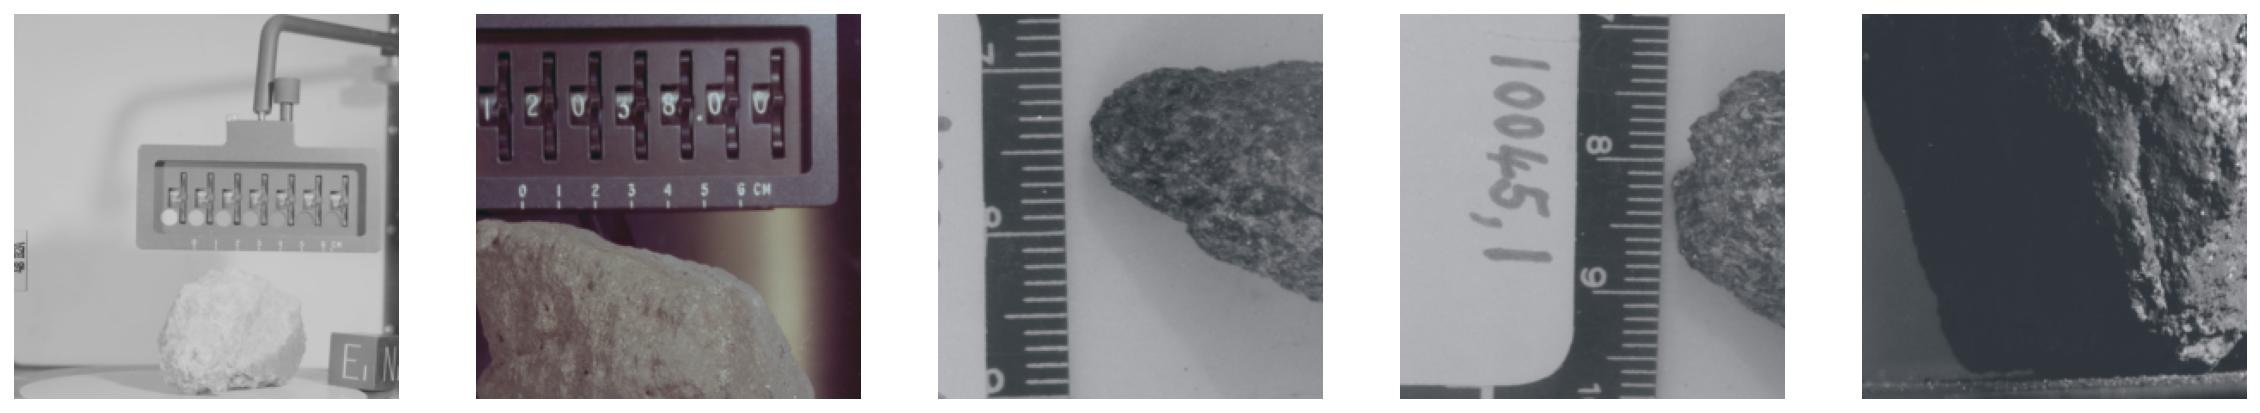

In [4]:
# How many images do you want to see? It's set to 5, but you can change the number.
images, labels = get_random_images(5)
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20,20))
classes = trainloader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    plt.axis('off')
    plt.imshow(image)
plt.show()

Теперь давайте создадим нейронную сеть или сеть глубокого обучения для изучения взаимосвязей между признаками (например, краями, изгибами и текстурой) и каждым типом камня.

Принцип работы нейронной сети очень похож на работу мозга человека. Человеческий мозг состоит из нейронов или нервных клеток, которые передают и обрабатывают информацию, получаемую от органов чувств. Многие из нервных клеток объединены вместе, образуя нервные связи в нашем мозге. Нервные связи передают электрические импульсы от одного нейрона к следующему.

Выполните следующий код, чтобы сообщить компьютеру наиболее эффективный способ создания нейронной сети:

In [5]:
# Determine whether you're using a CPU or a GPU to build the deep learning network.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

Нейронные сети имеют миллионы нейронов и нервных связей. Чтобы создать функциональную нейронную сеть, мы объединим все компоненты в два этапа:

 1. Создайте все нейроны.
 2. Соедините нейроны соответствующим образом (существуют тысячи способов соединения нейронов).

In [6]:
# Builds all the neurons.
for param in model.parameters():
    param.requires_grad = False

# The parameters of our deep learning model.
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)
print('done')

done


Теперь, когда мы создали нейронную сеть и предоставили программу для определения различных признаков космических камней, нам следует обучить программу. На этом шаге мы используем наши обучающие данные, чтобы наша программа очень точно классифицировала космические породы.

Скопируйте приведенный ниже код в ячейку и запустите его. В этом коде необходимо найти переменную `epochs`. Эта переменная сообщает программе, сколько раз следует искать связи в признаках. Изначально она имеет значение 5, но вы можете увеличить это число, чтобы повысить точность. Однако увеличение этого числа приводит к значительному повышению скорости выполнения кода.

In [7]:
epochs = 5
steps = 0
running_loss = 0
print_every = 5
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        print('Training step ', steps)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Training step  1
Training step  2
Training step  3
Training step  4
Training step  5
Epoch 1/5.. Train loss: 2.232.. Test loss: 2.532.. Test accuracy: 0.517
Training step  6
Training step  7
Training step  8
Training step  9
Training step  10
Epoch 2/5.. Train loss: 1.244.. Test loss: 0.660.. Test accuracy: 0.615
Training step  11
Training step  12
Training step  13
Training step  14
Training step  15
Epoch 2/5.. Train loss: 0.510.. Test loss: 0.437.. Test accuracy: 0.838
Training step  16
Training step  17
Training step  18
Training step  19
Training step  20
Epoch 3/5.. Train loss: 0.402.. Test loss: 0.280.. Test accuracy: 0.902
Training step  21
Training step  22
Training step  23
Training step  24
Training step  25
Epoch 4/5.. Train loss: 0.331.. Test loss: 0.187.. Test accuracy: 0.969
Training step  26
Training step  27
Training step  28
Training step  29
Training step  30
Epoch 4/5.. Train loss: 0.270.. Test loss: 0.215.. Test accuracy: 0.933
Training step  31
Training step  32
T

Основная часть ИИ — это степень точности при прогнозировании правильного результата. В нашем случае точность заключается в том, с какой долей вероятности компьютер должен правильно определить камень, показанный на изображении, как тип, который специалисты определили вручную. Точность 0,96 означает, что 96% камней спрогнозированы правильно, а 4% — неправильно.

Следующий код вычисляет способность нашей системы ИИ точно классифицировать космические породы:

In [108]:
print(accuracy / len(testloader))

1.0


Как видно, точность этой модели очень высока. Это именно то, что нам нужно, поскольку это означает, что модель является подходящей для выполнения прогнозов.

Несмотря на то, что показатель в 96% достаточно высок, вы можете выполнить еще несколько дополнительных действий для повышения точности.

 - Добавьте больше изображений для обучения моделей искусственного интеллекта.
 - Увеличьте эпоху (число итераций обучения для глубокого обучения).

Теперь, когда мы создали нейронную сеть и проверили точность, сохраните ее:

In [9]:
torch.save(model, 'aerialmodel.pth')

Давайте проверим работу нашей модели. Чтобы спрогнозировать тип камня на новом изображении, необходимо выполнить следующие действия.

1. Преобразуйте новое изображение в числа.
2. Преобразуйте изображение: обрежьте его и измените его размер до 224 × 224 пикселей.
3. Извлеките признаки и характеристики изображения.
4. Спрогнозируйте тип камня, показанного на изображении, с помощью взаимосвязей, изученных на шаге 2.

Следующий код загружает нейронную сеть:
```Python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('aerialmodel.pth')
```

In [10]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

Давайте выберем пять случайных изображений и посмотрим, сможет ли наша модель определить, к какому именно типу относится камень.

Следующий код получает пять случайных изображений и хранит их данные в переменных. Мы используем пять изображений для тестирования системы ИИ, но вы можете выбрать любое число.

In [11]:
images, labels = get_random_images(8)

Этот код визуализирует новые изображения и добавляет заголовки, указывающие, какой тип камня был определен моделью по фотографии.

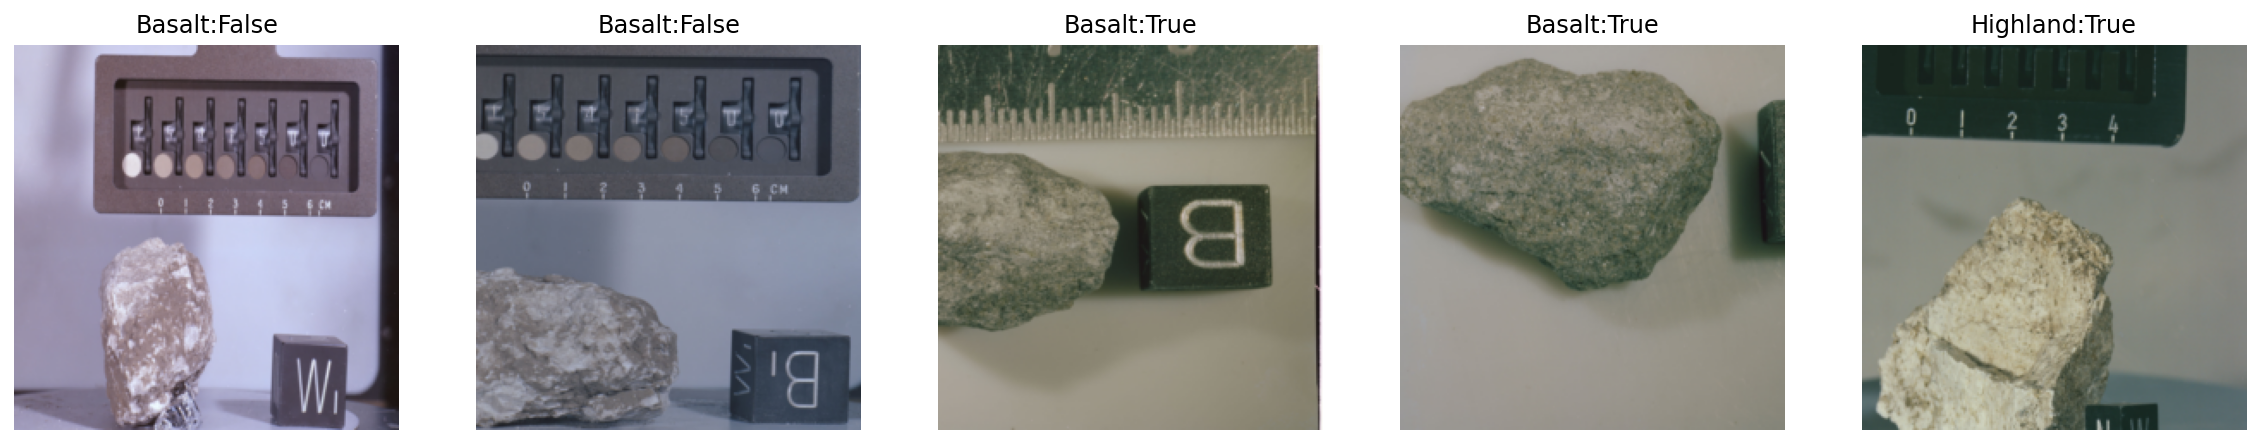

In [12]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig = plt.figure(figsize=(20, 10))

classes=trainloader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

Примеры изображений помечаются как Фактический тип камня: истина/ложь.

Истина и Ложь указывают, правильно ли наша система ИИ классифицировала камень на изображении.

# Планирование полета на Луну с помощью библиотеки pandas

In [13]:
rock_samples = pd.read_csv('https://raw.githubusercontent.com/sguthals/learnwithdrg/main/OverTheMoon/sample-return/data/rocksamples.csv') 
rock_samples.head()

,ID,Mission,Type,Subtype,Weight (g),Pristine (%)
0,10001,Apollo11,Soil,Unsieved,125.8,88.36
1,10002,Apollo11,Soil,Unsieved,5629.0,93.73
2,10003,Apollo11,Basalt,Ilmenite,213.0,65.56
3,10004,Apollo11,Core,Unsieved,44.8,71.76
4,10005,Apollo11,Core,Unsieved,53.4,40.31


Из этих данных можно увидеть, что в результате миссий "Аполлон" было собрано 2229 образцов. Из образца данных можно увидеть, что каждая строка содержит следующие значения:

- `ID` — уникальный идентификатор, используемый для отслеживания образца в НАСА.
- `Mission` — миссия, которая вернула образец.
- `Type` — тип образца (породы или другой сущности).
- `Subtype` — более конкретная классификация типов.
- `Weight (g)` — исходный вес образца в граммах.
- `Pristine (%)` — оставшаяся доля образца (часть его используется для исследований).

## Определение вопроса, который необходимо задать для очистки данных

Прежде чем продолжить, важно определить, какие сведения необходимо использовать, чтобы дать рекомендацию астронавтам. В данном случае наиболее доступной информацией, которая может повлиять на массу возвращаемых образцов, является тип космического корабля.

### Преобразование массы образцов
Хотя подробные характеристики ракет являются закрытой информацией, некоторые сведения являются общедоступными, например масса модулей (частей ракет), в которых образцы будут возвращаться на Землю, и общая масса груза, с которым ракета может покинуть атмосферу.

Подробнее мы разберем эти данные в одном из следующих уроков, пока же важно отметить, что масса ракет часто измеряется в килограммах, а не граммах. Поэтому, чтобы упростить анализ данных в дальнейшем, их следует обработать, преобразовав массу образцов в килограммы.

In [14]:
rock_samples['Weight (g)'] = rock_samples['Weight (g)'].apply(lambda x : x * 0.001)
rock_samples.rename({'Weight (g)':'Weight (kg)'}, axis=1, inplace=True)
rock_samples.head()

,ID,Mission,Type,Subtype,Weight (kg),Pristine (%)
0,10001,Apollo11,Soil,Unsieved,0.1258,88.36
1,10002,Apollo11,Soil,Unsieved,5.6290,93.73
2,10003,Apollo11,Basalt,Ilmenite,0.2130,65.56
3,10004,Apollo11,Core,Unsieved,0.0448,71.76
4,10005,Apollo11,Core,Unsieved,0.0534,40.31


Сначала мы изменили значения в столбце `Weight (g)`, умножив их на 0,001. Затем мы исправили имя столбца, изменив его на `Weight (kg)`.

## Создание кадра данных
В pandas, библиотеке Python, которую мы применяем для анализа данных, есть "кадры данных", которые позволяют эффективно представлять двумерные данные. Возможно, вы обратили внимание, что при выполнении кода `rock_samples.head()` выводимый результат очень похож на лист Excel. Кадры данных действительно удобно представлять как такие листы.

В кадре данных `rock_samples` имеется по одной строке для каждого собранного образца. Однако, как мы уже упоминали, мы хотим проанализировать образцы в совокупности в их связи с конкретными ракетами, на которых они были возвращены.

Создайте кадр данных с именем `missions`, в котором будет содержаться сводка данных для каждой из шести миссий "Аполлон", вернувших образцы. Создайте в этом кадре данных столбец с именем Mission (Миссия) с одной строкой для каждой миссии.

In [15]:
missions = pd.DataFrame()
missions['Mission'] = rock_samples['Mission'].unique()
missions.head()

,Mission
0,Apollo11
1,Apollo12
2,Apollo14
3,Apollo15
4,Apollo16


## Суммарный вес образцов по миссии
Теперь в кадр данных `missions` можно добавить новый столбец, представляющий суммарный вес всех образцов, собранных миссией.

In [16]:
sample_total_weight = rock_samples.groupby('Mission')['Weight (kg)'].sum()
missions = pd.merge(missions, sample_total_weight, on='Mission')
missions.rename({'Weight (kg)':'Sample Weight (kg)'}, axis=1, inplace=True)
missions

,Mission,Sample Weight (kg)
0,Apollo11,21.55424
1,Apollo12,34.34238
2,Apollo14,41.83363
3,Apollo15,75.39910
4,Apollo16,92.46262
5,Apollo17,109.44402


Давайте разберем этот код. Первую строку (`sample_total_weight = rock_samples.groupby('Mission')['Weight (kg)'].sum()`) можно разбить следующим образом:

 - `rock_samples.groupby('Mission')` — группировка всех строк по значениям в столбце Миссия.
 - `rock_samples.groupby('Mission')['Weight(kg)']` — получение всех значений в столбце Вес (кг) с группировкой по уникальным значениям в столбце Миссия.
 - `rock_samples.groupby('Mission')['Weight(kg)'].sum()` — суммирование всех значений в столбце Вес (кг) для каждого уникального значения в столбце Миссия.

Если вывести эту строку, вы получите ряд данных pandas, который по существу представляет собой одномерный тип данных или список. Вместо номера в качестве индекса для этого списка будет выступать уникальное значение из столбца Миссия:

In [17]:
sample_total_weight = rock_samples.groupby('Mission')['Weight (kg)'].sum()
sample_total_weight

Mission
Apollo11     21.55424
Apollo12     34.34238
Apollo14     41.83363
Apollo15     75.39910
Apollo16     92.46262
Apollo17    109.44402
Name: Weight (kg), dtype: float64

Следующую строку (`pd.merge(missions, sample_total_weight, on='Mission')`) можно описать следующим образом:

>Объединение кадра данных `missions` с рядом данных `sample_total_weight` с использованием столбца Миссия в качестве индекса для объединения. Таким образом, компьютер будет выполнять следующие действия: для каждого значения в столбце Миссии в кадре данных `missions` выполняется поиск соответствующего значения в ряде данных `sample_total_weight`, после чего значение из ряда данных добавляется в виде нового столбца в строку в кадре данных.

Этот пример содержит всего шесть строк и поэтому достаточно прост. Например, мы можем убедиться, что в строку "Аполлон-11" в кадре данных `missions` было добавлено значение 21,55424.

В следующей строке столбец переименовывается, как и раньше, чтобы гарантировать конкретность данных.

Последняя строка выводит весь кадр данных `missions`. Поскольку мы используем данные всего по шести миссиям, выведенные в полном объеме данные кадра будет по-прежнему легко анализировать. При этом нет необходимости использовать `head()` для вывода только первых пяти строк.

## Определение разницы в весе между различными миссиями
Поскольку мы не являемся специалистами в ракетостроении, нам важно уметь анализировать различные срезы доступных данных. В этом случае мы видим, что общий вес образцов с каждой миссией увеличивался, однако сразу определить, на какую величину, достаточно сложно. Мы можем добавить в кадр данных `missions` один столбец, в котором будет фиксироваться разница между текущей и предшествующей строкой:

In [18]:
missions['Weight Diff'] = missions['Sample Weight (kg)'].diff()
missions

,Mission,Sample Weight (kg),Weight Diff
0,Apollo11,21.55424,NaN
1,Apollo12,34.34238,12.78814
2,Apollo14,41.83363,7.49125
3,Apollo15,75.39910,33.56547
4,Apollo16,92.46262,17.06352
5,Apollo17,109.44402,16.98140


Обратите внимание, что в первой строке (миссия "Аполлон-11") столбец Разница по весу содержит значение `NaN`. Это значение `NULL`. Поскольку миссия "Аполлон-11" была первой, данные по предшествующей ей миссии попросту отсутствуют. Вместо этого значения `NaN` мы можем указать значение 0:



In [19]:
missions['Weight Diff'] = missions['Weight Diff'].fillna(value=0)
missions

,Mission,Sample Weight (kg),Weight Diff
0,Apollo11,21.55424,0.00000
1,Apollo12,34.34238,12.78814
2,Apollo14,41.83363,7.49125
3,Apollo15,75.39910,33.56547
4,Apollo16,92.46262,17.06352
5,Apollo17,109.44402,16.98140


В этом коде Python выполняются следующие действия:

Просматривается только столбец Разница по весу из кадра данных `missions`.
Все значения, равные `NULL` или не являющиеся числом, заполняются определенным значением.
Вместо значений, не являющихся числом, указывается значение 0.
Измененный список значений сохраняется в исходный столбец.
Последний шаг очень важен. Pandas — это библиотека, предназначенная для исследования данных. Это значит, что некоторые ее функции предоставляют аналитические сведения о данных, но не изменяют их напрямую. Если вы сомневаетесь в чем-либо, сначала ознакомьтесь с документацией и проведите тестирование!

Используя Согласованный архив данных НАСА по космонавтике, мы собрали сведения о каждом модуле, использовавшемся в каждой миссии. Как и при создании таблиц образцов, создайте шесть столбцов: три для лунных модулей и три для командных.

- Имя модуля
- Масса модуля
- Разница по массе модуля
Замените все `NaN` значения на 0:

In [20]:
missions['Lunar Module (LM)'] = {'Eagle (LM-5)', 'Intrepid (LM-6)',
                                 'Antares (LM-8)', 'Falcon (LM-10)',
                                 'Orion (LM-11)', 'Challenger (LM-12)'}
missions['LM Mass (kg)'] = {15103, 15235, 15264, 16430, 16445, 16456}
missions['LM Mass Diff'] = missions['LM Mass (kg)'].diff()
missions['LM Mass Diff'] = missions['LM Mass Diff'].fillna(0)

missions['Command Module (CM)'] = {'Columbia (CSM-107)', 'Yankee Clipper (CM-108)',
                                   'Kitty Hawk (CM-110)', 'Endeavor (CM-112)',
                                   'Casper (CM-113)', 'America (CM-114)'}
missions['CM Mass (kg)'] = {5560, 5609, 5758, 5875, 5840, 5960}
missions['CM Mass Diff'] = missions['CM Mass (kg)'].diff()
missions['CM Mass Diff'] = missions['CM Mass Diff'].fillna(0)

missions

,Mission,Sample Weight (kg),Weight Diff,Lunar Module (LM),LM Mass (kg),LM Mass Diff,Command Module (CM),CM Mass (kg),CM Mass Diff
0,Apollo11,21.55424,0.00000,Eagle (LM-5),15264,0.0,Columbia (CSM-107),5960,0.0
1,Apollo12,34.34238,12.78814,Orion (LM-11),15235,-29.0,America (CM-114),5609,-351.0
2,Apollo14,41.83363,7.49125,Falcon (LM-10),16456,1221.0,Endeavor (CM-112),5840,231.0
3,Apollo15,75.39910,33.56547,Challenger (LM-12),16430,-26.0,Yankee Clipper (CM-108),5875,35.0
4,Apollo16,92.46262,17.06352,Antares (LM-8),16445,15.0,Kitty Hawk (CM-110),5560,-315.0
5,Apollo17,109.44402,16.98140,Intrepid (LM-6),15103,-1342.0,Casper (CM-113),5758,198.0


Мы можем добавить ряд суммарных значений для лунных и командных модулей каждой миссии:

In [21]:
missions['Total Weight (kg)'] = missions['LM Mass (kg)'] + missions['CM Mass (kg)']
missions['Total Weight Diff'] = missions['LM Mass Diff'] + missions['CM Mass Diff']
missions

,Mission,Sample Weight (kg),Weight Diff,Lunar Module (LM),LM Mass (kg),LM Mass Diff,Command Module (CM),CM Mass (kg),CM Mass Diff,Total Weight (kg),Total Weight Diff
0,Apollo11,21.55424,0.00000,Eagle (LM-5),15264,0.0,Columbia (CSM-107),5960,0.0,21224,0.0
1,Apollo12,34.34238,12.78814,Orion (LM-11),15235,-29.0,America (CM-114),5609,-351.0,20844,-380.0
2,Apollo14,41.83363,7.49125,Falcon (LM-10),16456,1221.0,Endeavor (CM-112),5840,231.0,22296,1452.0
3,Apollo15,75.39910,33.56547,Challenger (LM-12),16430,-26.0,Yankee Clipper (CM-108),5875,35.0,22305,9.0
4,Apollo16,92.46262,17.06352,Antares (LM-8),16445,15.0,Kitty Hawk (CM-110),5560,-315.0,22005,-300.0
5,Apollo17,109.44402,16.98140,Intrepid (LM-6),15103,-1342.0,Casper (CM-113),5758,198.0,20861,-1144.0


Теперь у вас есть представление о каждой из шести миссий "Аполлон" с высадкой на Луну. Эта картина содержит сведения об образцах, собранных каждой миссией, и о весе каждого лунного и командного модуля.

## Сравнение данных
Спрогнозировать вес образцов, которые могут быть доставлены на Землю в рамках миссии "Артемида", сложно, поскольку нам неизвестны полные технические характеристики космических кораблей, которые будут использоваться для этого. Однако при этом у нас есть данные по весу и полезной нагрузке из информационного бюллетеня NASA по системе запуска Space Launch System (SLS) и модулям "Орион" .

Под полезной нагрузкой фактически понимается общий вес, который ракета-носитель способна вывести через атмосферу в космос. Таким образом, высока вероятность того, что величина полезной нагрузки будет более точным прогностическим фактором по сравнению с весом каждого модуля, поскольку от ее определения с высокой вероятностью зависят многие конструкторские решения.

Мы знаем, что полезная нагрузка ракеты-носителя "Сатурн-5" составляет 43 500 кг, а вес модулей в зависимости от миссии может изменяться. Таким образом, для определения соотношений, на основании которых мы можем строить прогнозы для миссии "Артемида", мы можем использовать следующие данные:

- Полезная нагрузка ракеты-носителя "Сатурн-5"
- Вес образцов, доставленных в рамках миссии
- Вес модуля, используемого в рамках миссии

In [22]:
# Sample-to-weight ratio
saturnVPayload = 43500
missions['Crewed Area : Payload'] = missions['Total Weight (kg)'] / saturnVPayload
missions['Sample : Crewed Area'] = missions['Sample Weight (kg)'] / missions['Total Weight (kg)']
missions['Sample : Payload'] = missions['Sample Weight (kg)'] / saturnVPayload
missions

,Mission,Sample Weight (kg),Weight Diff,Lunar Module (LM),LM Mass (kg),LM Mass Diff,Command Module (CM),CM Mass (kg),CM Mass Diff,Total Weight (kg),Total Weight Diff,Crewed Area : Payload,Sample : Crewed Area,Sample : Payload
0,Apollo11,21.55424,0.00000,Eagle (LM-5),15264,0.0,Columbia (CSM-107),5960,0.0,21224,0.0,0.487908,0.001016,0.000495
1,Apollo12,34.34238,12.78814,Orion (LM-11),15235,-29.0,America (CM-114),5609,-351.0,20844,-380.0,0.479172,0.001648,0.000789
2,Apollo14,41.83363,7.49125,Falcon (LM-10),16456,1221.0,Endeavor (CM-112),5840,231.0,22296,1452.0,0.512552,0.001876,0.000962
3,Apollo15,75.39910,33.56547,Challenger (LM-12),16430,-26.0,Yankee Clipper (CM-108),5875,35.0,22305,9.0,0.512759,0.003380,0.001733
4,Apollo16,92.46262,17.06352,Antares (LM-8),16445,15.0,Kitty Hawk (CM-110),5560,-315.0,22005,-300.0,0.505862,0.004202,0.002126
5,Apollo17,109.44402,16.98140,Intrepid (LM-6),15103,-1342.0,Casper (CM-113),5758,198.0,20861,-1144.0,0.479563,0.005246,0.002516


## Сохранение соотношений
После этого можно использовать функцию `mean()`, чтобы получить среднее значение для всех этих соотношений по всем миссиям.

In [23]:
crewedArea_payload_ratio = missions['Crewed Area : Payload'].mean()
sample_crewedArea_ratio = missions['Sample : Crewed Area'].mean()
sample_payload_ratio = missions['Sample : Payload'].mean()
print(crewedArea_payload_ratio)
print(sample_crewedArea_ratio)
print(sample_payload_ratio)

0.49630268199233724
0.0028946732226251396
0.0014369195019157093


На основе полученных коэффициентов можно спрогнозировать вес образцов, которые могут быть доставлены на Землю в рамках миссии "Артемида".

## Создание кадра данных для миссий "Артемида"
О миссии "Артемида" нам известно не все, но в настоящее время мы знаем, что для полетов будут использоваться три серии ракет. Каждая ракета будет иметь один обитаемый вариант и один вариант исключительно для перевозки грузов. В рамках этого модуля мы сосредоточимся только на обитаемых ракетах. Мы также знаем, что планируемая грузоподъемность ракеты-носителя Space Launch System (SLS) должна увеличиваться с каждой серией, но космический корабль "Орион", согласно текущим планам, будет иметь одну массу (включая команду и лунные модули).

Мы будем называть команду и лунные модули обитаемой зоной и можем создать кадр данных с известной информацией о трех пилотируемых миссиях:

In [24]:
artemis_crewedArea = 26520
artemis_mission = pd.DataFrame({'Mission':['artemis1','artemis1b','artemis2'],
                                 'Total Weight (kg)':[artemis_crewedArea,
                                                      artemis_crewedArea,
                                                      artemis_crewedArea],
                                 'Payload (kg)':[26988, 37965, 42955]})
artemis_mission

,Mission,Total Weight (kg),Payload (kg)
0,artemis1,26520,26988
1,artemis1b,26520,37965
2,artemis2,26520,42955


Кроме того, мы можем оценить массу образцов на основе соотношений, установленных для миссий "Артемида":

In [25]:
artemis_mission['Sample Weight from Total (kg)'] = artemis_mission['Total Weight (kg)'] * \
                                                          sample_crewedArea_ratio
artemis_mission['Sample Weight from Payload (kg)'] = artemis_mission['Payload (kg)'] * \
                                                          sample_payload_ratio
artemis_mission

,Mission,Total Weight (kg),Payload (kg),Sample Weight from Total (kg),Sample Weight from Payload (kg)
0,artemis1,26520,26988,76.766734,38.779584
1,artemis1b,26520,37965,76.766734,54.552649
2,artemis2,26520,42955,76.766734,61.722877


Наконец, можно получить среднее от двух прогнозов:

In [26]:
artemis_mission['Estimated Sample Weight (kg)'] = \
        (artemis_mission['Sample Weight from Payload (kg)'] + 
         artemis_mission['Sample Weight from Total (kg)']) / 2
artemis_mission

,Mission,Total Weight (kg),Payload (kg),Sample Weight from Total (kg),Sample Weight from Payload (kg),Estimated Sample Weight (kg)
0,artemis1,26520,26988,76.766734,38.779584,57.773159
1,artemis1b,26520,37965,76.766734,54.552649,65.659691
2,artemis2,26520,42955,76.766734,61.722877,69.244806


Теперь видно, что миссии "Артемида", скорее всего, смогут вернуть 57,77 кг, 65,65 кг и 69,24 кг соответственно.

Следующий вопрос заключается в том, породам каких типов следует отдавать приоритет.

Для определения того, какие типы образцов следует собирать на Луне требуются специальные знания, но мы можем сделать ряд предположений для обучения способам очистки и обработки данных.

Во-первых, мы можем определить, сколько осталось от каждого образца, привезенного миссиями "Аполлон", исходя из первоначальной массы и оставшейся доли в процентах.

In [27]:
rock_samples['Remaining (kg)'] = rock_samples['Weight (kg)'] * \
                                (rock_samples['Pristine (%)'] * .01)
rock_samples.head()

,ID,Mission,Type,Subtype,Weight (kg),Pristine (%),Remaining (kg)
0,10001,Apollo11,Soil,Unsieved,0.1258,88.36,0.111157
1,10002,Apollo11,Soil,Unsieved,5.6290,93.73,5.276062
2,10003,Apollo11,Basalt,Ilmenite,0.2130,65.56,0.139643
3,10004,Apollo11,Core,Unsieved,0.0448,71.76,0.032148
4,10005,Apollo11,Core,Unsieved,0.0534,40.31,0.021526


Использовать функцию `head()` или `info()` для кадра данных `rock_samples` на этом этапе не имеет смысла. Учитывая, что образцов более 2000, понять, о чем говорят результаты, будет трудно. Можно использовать функцию `describe()`:

In [28]:
rock_samples.describe()

,ID,Weight (kg),Pristine (%),Remaining (kg)
count,2229.000000,2229.000000,2229.000000,2229.000000
mean,52058.432032,0.168253,84.512764,0.138103
std,26207.651471,0.637286,22.057299,0.525954
min,10001.000000,0.000000,0.000000,0.000000
25%,15437.000000,0.003000,80.010000,0.002432
50%,65527.000000,0.010200,92.300000,0.008530
75%,72142.000000,0.093490,98.140000,0.078240
max,79537.000000,11.729000,180.000000,11.169527


Мы видим, что в среднем каждый образец весит около 0,16 кг и сохраняет около 84% объема. Эти знания можно использовать для извлечения только тех образцов, которые потеряли больше всего объема, то есть активно использовались исследователями.

In [29]:
low_samples = rock_samples.loc[(rock_samples['Weight (kg)'] >= .16)  &
                               (rock_samples['Pristine (%)'] <= 50)]
low_samples.head()

,ID,Mission,Type,Subtype,Weight (kg),Pristine (%),Remaining (kg)
11,10017,Apollo11,Basalt,Ilmenite,0.973,43.71,0.425298
14,10020,Apollo11,Basalt,Ilmenite,0.425,27.88,0.118490
15,10021,Apollo11,Breccia,Regolith,0.250,30.21,0.075525
29,10045,Apollo11,Basalt,Olivine,0.185,12.13,0.022441
37,10057,Apollo11,Basalt,Ilmenite,0.919,35.15,0.323028


Скорее всего, 27 образцов будет недостаточно, чтобы составить рекомендации. Возможно, мы можем найти другие образцы, необходимые для более подробного исследования на Земле. Для этого можно использовать функцию `unique()`, чтобы узнать, сколько уникальных типов есть в кадрах данных `low_samples` и `rock_samples`.

In [30]:
low_samples.Type.unique()

array(['Basalt', 'Breccia', 'Soil', 'Core'], dtype=object)

In [31]:
rock_samples.Type.unique()

array(['Soil', 'Basalt', 'Core', 'Breccia', 'Special', 'Crustal'],
      dtype=object)

Мы видим, что, хотя шесть уникальных типов были собраны во всех образцах, активно используемые образцы относятся только к четырем уникальным типам. Но это не полная информация об образцах. Например, сколько образцов каждого типа потеряли большой вес в кадре данных `low_samples`?

In [32]:
low_samples['Type'].value_counts() # np.unique(low_samples['Type'], return_counts=True)

Basalt     14
Breccia     8
Soil        4
Core        1
Name: Type, dtype: int64

Обратите внимание, что образцов базальта и брекчии больше, чем батолита и грунта. Кроме того, поскольку, скорее всего, в каждой миссии существуют требования по сбору батолита и грунта, мы можем сосредоточиться на базальте и брекчии:

In [33]:
needed_samples = low_samples[low_samples['Type'].isin(['Basalt', 'Breccia'])]
needed_samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 11 to 2183
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              22 non-null     int64  
 1   Mission         22 non-null     object 
 2   Type            22 non-null     object 
 3   Subtype         22 non-null     object 
 4   Weight (kg)     22 non-null     float64
 5   Pristine (%)    22 non-null     float64
 6   Remaining (kg)  22 non-null     float64
dtypes: float64(3), int64(1), object(3)
memory usage: 1.4+ KB


Но нужны ли нам только два типа пород?

Давайте сделаем шаг назад и посмотрим, как число образцов сравнимо с объемом образца. Можно сравнить общий вес из кадра данных `needed_samples` с кадром данных `rock_samples`. То есть мы будем сравнивать образцы, которые мы определили как истощающиеся, со всеми образцами, собранными миссиями "Аполлона".

In [34]:
needed_samples.groupby('Type')['Weight (kg)'].sum()

Type
Basalt     17.4234
Breccia    10.1185
Name: Weight (kg), dtype: float64

In [35]:
rock_samples.groupby('Type')['Weight (kg)'].sum()

Type
Basalt      93.14077
Breccia    168.88075
Core        19.93587
Crustal      4.74469
Soil        87.58981
Special      0.74410
Name: Weight (kg), dtype: float64

Один элемент данных резко выделяется: у нас всегда было мало образцов корковых пород.

Их можно добавить в набор необходимых образцов:

In [36]:
needed_samples = needed_samples.append(rock_samples.loc[rock_samples['Type'] == 'Crustal'])
needed_samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68 entries, 11 to 2189
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              68 non-null     int64  
 1   Mission         68 non-null     object 
 2   Type            68 non-null     object 
 3   Subtype         68 non-null     object 
 4   Weight (kg)     68 non-null     float64
 5   Pristine (%)    68 non-null     float64
 6   Remaining (kg)  68 non-null     float64
dtypes: float64(3), int64(1), object(3)
memory usage: 4.2+ KB


## Сводка по необходимым образцам
Наконец, нужно объединить все, что мы знаем, в одну таблицу, которую можно предоставить астронавтам. Во-первых, нам нужен столбец для каждого типа породы, который мы определили как нужный:

In [37]:
needed_samples_overview = pd.DataFrame()
needed_samples_overview['Type'] = needed_samples.Type.unique()
needed_samples_overview

,Type
0,Basalt
1,Breccia
2,Crustal


Далее нам нужна общая масса каждого типа породы, собранная изначально:

In [38]:
needed_sample_weights = needed_samples.groupby('Type')['Weight (kg)'].sum().reset_index()
needed_samples_overview = pd.merge(needed_samples_overview,
                                   needed_sample_weights, on='Type')
needed_samples_overview.rename({'Weight (kg)':'Total Weight (kg)'}, axis=1, inplace=True)
needed_samples_overview

,Type,Total Weight (kg)
0,Basalt,17.42340
1,Breccia,10.11850
2,Crustal,4.74469


Когда астронавты будут на Луне, они смогут определять тип породы, помимо прочего, по размеру. Если мы сможем сообщить им приблизительный размер образца породы каждого типа, это упростит процесс сбора.

In [39]:
needed_sample_ave_weights = needed_samples.groupby('Type')['Weight (kg)'] \
                                                                 .mean().reset_index()
needed_samples_overview = pd.merge(needed_samples_overview,
                                   needed_sample_ave_weights, on='Type')
needed_samples_overview.rename({'Weight (kg)': 'Ave Weight (kg)'}, axis=1, inplace=True)
needed_samples_overview

,Type,Total Weight (kg),Ave Weight (kg)
0,Basalt,17.42340,1.244529
1,Breccia,10.11850,1.264812
2,Crustal,4.74469,0.103145


Корковые породы отличаются небольшим размером. Их может быть труднее заметить, поэтому неудивительно, что у нас их так мало.

Скорее всего, астронавтам желательно дать указания касательно того, какое количество каждого типа мы хотим получить. Таким образом, для каждого из трех типов породы следует взять общее имеющееся количество и получить оставшийся процент.

In [40]:
total_rock_count = rock_samples.groupby('Type')['ID'].count().reset_index()
needed_samples_overview = pd.merge(needed_samples_overview, total_rock_count, on='Type')
needed_samples_overview.rename({'ID':'Number of Samples'}, axis=1, inplace=True)
total_rocks = needed_samples_overview['Number of Samples'].sum()
needed_samples_overview['Percentage of Rocks'] = \
                              needed_samples_overview['Number of Samples'] / total_rocks
needed_samples_overview

,Type,Total Weight (kg),Ave Weight (kg),Number of Samples,Percentage of Rocks
0,Basalt,17.42340,1.244529,351,0.258850
1,Breccia,10.11850,1.264812,959,0.707227
2,Crustal,4.74469,0.103145,46,0.033923


Наконец, чтобы связать все это с рекомендациями для программы "Артемида", мы можем определить среднюю массу образцов, которые мы оценили в предыдущем уроке.

In [41]:
artemis_ave_weight = artemis_mission['Estimated Sample Weight (kg)'].mean()
artemis_ave_weight

64.22588520079607

С помощью полученного числа можно определить, какое количество образцов каждой породы должны собрать астронавты.

In [42]:
needed_samples_overview['Weight to Collect'] = \
                       needed_samples_overview['Percentage of Rocks'] * artemis_ave_weight

needed_samples_overview['Rocks to Collect'] = needed_samples_overview['Weight to Collect'] \
                                            / needed_samples_overview['Ave Weight (kg)']

needed_samples_overview

,Type,Total Weight (kg),Ave Weight (kg),Number of Samples,Percentage of Rocks,Weight to Collect,Rocks to Collect
0,Basalt,17.42340,1.244529,351,0.258850,16.624842,13.358345
1,Breccia,10.11850,1.264812,959,0.707227,45.422289,35.912271
2,Crustal,4.74469,0.103145,46,0.033923,2.178754,21.123128


Итак, мы могли бы посоветовать астронавтам Артемиды собрать 13 базальтовых камней, 35 камней брекчии и 21 камень корковой породы. 

# Прогнозирование метеорных дождей

Теперь пора подготовить данные для создания модели прогнозирования. Напомним, что в идеале этот этап должен выполняться под руководством эксперта по метеорам. Но даже без его помощи мы можем предположить, какие данные помогут нам определить наилучшую дату для наблюдения за метеорным дождем.

Прежде чем собирать данные, важно определить, какие данные нужно найти. Нам известно следующее:

- Метеорные дожди обычно вызываются метеорными телами, отделившимися от комет в результате их таяния.
- Кометы движутся вокруг солнца по орбитам, которые можно наблюдать и прогнозировать.
- Из-за яркой луны увидеть метеорный дождь труднее.
- Орбита и вращение Земли влияют на то, где можно наблюдать метеорный дождь.

## Выбор рассматриваемых комет
Хотя источниками метеоритных тел могут быть кометы, астероиды, планеты и их спутники, в этом модуле мы сосредоточимся на телах, отделившихся от известных комет. Для прогнозирования того, когда и где будут видны метеорные дожди, обычно берут четыре кометы. Они описываются в следующих разделах.

### Комета Тэтчера
<a href="https://solarsystem.nasa.gov/asteroids-comets-and-meteors/comets/c-1861-g1-thatcher/in-depth/">Комета Тэтчера</a> была впервые обнаружена в 1861 году. Ее оборот вокруг Солнца занимает 415,5 года.

Осколки этой кометы каждый апрель вызывают <a href="https://solarsystem.nasa.gov/asteroids-comets-and-meteors/meteors-and-meteorites/lyrids/in-depth/">метеорный поток Лириды</a>. Первое письменно зафиксированное наблюдение потока Лириды датируется 687 годом до нашей эры.

Метеоры потока Лириды кажутся вылетающими из созвездия Лиры. Однако на самом деле комета и ее метеоры прилетают не из самого созвездия.

### Комета Галлея
<a href="https://solarsystem.nasa.gov/asteroids-comets-and-meteors/comets/1p-halley/in-depth/">Комета Галлея</a> была впервые обнаружена в 1531 году. Однако лишь в 1705 году было установлено, что кометы, которые наблюдались в 1531, 1607 и 1682 годах, — это одно и то же небесное тело.

Оборот кометы Галлея вокруг Солнца занимает 76 лет. Ее осколки каждый май вызывают <a href="https://solarsystem.nasa.gov/asteroids-comets-and-meteors/meteors-and-meteorites/eta-aquarids/in-depth/">метеорный поток эта-Аквариды</a>, а каждый октябрь — <a href="https://solarsystem.nasa.gov/asteroids-comets-and-meteors/meteors-and-meteorites/orionids/in-depth/">поток Ориониды</a>.

Метеоры потока эта-Аквариды кажутся вылетающими из созвездия Водолея. Метеоры потока Ориониды кажутся вылетающими из созвездия Ориона.

### Комета Свифта-Туттля
<a href="https://solarsystem.nasa.gov/asteroids-comets-and-meteors/comets/109p-swift-tuttle/in-depth/">Комета Свифта-Туттля</a> была впервые обнаружена в 1862 году. Ее оборот вокруг Солнца занимает 133 года. Осколки этой кометы каждый август вызывают <a href="https://solarsystem.nasa.gov/asteroids-comets-and-meteors/meteors-and-meteorites/perseids/in-depth/">метеорный поток Персеиды</a>.

Но то, что источником этого потока является именно комета Свифта-Туттля, было установлено лишь в 1865 году. Метеоры потока Персеиды кажутся вылетающими из созвездия Персея.

### Комета Темпеля-Туттля
<a href="https://solarsystem.nasa.gov/asteroids-comets-and-meteors/comets/55p-tempel-tuttle/in-depth/">Комета Темпеля-Туттля</a> было открыта дважды разными астрономами независимо друг от друга в 1865 и 1866 годах. Ее оборот вокруг Солнца занимает 33 года. Осколки этой кометы каждый ноябрь вызывают метеорный поток Леониды.

Каждые 33 года <a href="https://solarsystem.nasa.gov/asteroids-comets-and-meteors/meteors-and-meteorites/leonids/in-depth/">поток Леониды</a> превращается в метеорный шторм . Это явление, когда в час наблюдается по крайней мере 1000 метеоров. Метеоры потока Леониды кажутся вылетающими из созвездия Льва.

### Фазы Луны
Так как Луна  обращается вокруг Земли, а Земля — вокруг Солнца, от Луны к Земле отражается разное количество света. Каждый месяц Луна проходит ряд фаз. Они соответствуют тому, от каких частей Луны мы видим отраженный свет.

Вот эти фазы.

- Новолуние: примерно 15-го числа месяца
- Растущая
- Полумесяц
- Первая четверть: примерно 23-го числа месяца
- Убывающая Луна
- Полнолуние: примерно 1-го числа месяца
- Убывающая Луна
- Третья четверть: около 10 числа месяца
- Старая Луна

Новая Луна, первая четверть, полная Луна и третья четверть — это наиболее отслеживаемые фазы. Фазы образуют цикл длиной 29 дней, поэтому точные даты зависят от количества дней в месяце.

## Файлы данных
Мы начали собирать некоторые данные для примера в этом модуле. Вы можете самостоятельно найти дополнительные данные, которые помогут вам прогнозировать метеорные дожди.

Вот данные, которые мы уже собрали:

- <a href="https://raw.githubusercontent.com/sguthals/learnwithdrg/main/OverTheMoon/meteor-showers/data/moonphases.csv">moonphases.csv</a> — файл с фазами Луны на каждый день 2020 года. Недостающие данные будут добавлены на следующем уроке. (Данные получены с сайта <a href="https://www.timeanddate.com/moon/phases/">timeanddate.com</a>)
- <a href="https://raw.githubusercontent.com/sguthals/learnwithdrg/main/OverTheMoon/meteor-showers/data/meteorshowers.csv">meteorshowers.csv</a> — файл с данными о пяти метеорных дождях, о которых мы говорили ранее. Данные включают в себя месяц, когда их лучше всего наблюдать, месяцы, когда они видимы, и предпочтительное полушарие. (Данные получены от <a href="https://solarsystem.nasa.gov/asteroids-comets-and-meteors/meteors-and-meteorites/in-depth/">НАСА</a>)
- <a href="https://raw.githubusercontent.com/sguthals/learnwithdrg/main/OverTheMoon/meteor-showers/data/constellations.csv">constellations.csv</a> — файл с данными о четырех созвездиях — источниках пяти метеорных дождей. Данные включают широты, в которых они видимы, и месяц для наилучшего обзора. (Данные получены из <a href="https://en.wikipedia.org/wiki/IAU_designated_constellations">Википедии</a>)
- <a href="https://raw.githubusercontent.com/sguthals/learnwithdrg/main/OverTheMoon/meteor-showers/data/cities.csv">cities.csv</a> — файл со списком столиц стран и соответствующей широтой. (Данные получены из <a href="https://en.wikipedia.org/wiki/List_of_national_capitals_by_latitude">Википедии</a>)

Вы можете также собрать данные других типов, которые могут повлиять на вероятность наблюдения метеорного дождя:

- Погода
- Другие кометы или известные метеоры
- Освещение в городе

## Импорт данных

In [305]:
meteor_showers = pd.read_csv('https://raw.githubusercontent.com/sguthals/learnwithdrg/main/OverTheMoon/meteor-showers/data/meteorshowers.csv')
moon_phases = pd.read_csv('https://raw.githubusercontent.com/sguthals/learnwithdrg/main/OverTheMoon/meteor-showers/data/moonphases.csv')
constellations = pd.read_csv('https://raw.githubusercontent.com/sguthals/learnwithdrg/main/OverTheMoon/meteor-showers/data/constellations.csv')
cities = pd.read_csv('https://raw.githubusercontent.com/sguthals/learnwithdrg/main/OverTheMoon/meteor-showers/data/cities.csv')

In [306]:
change_meteor_shower = {'name': 'Chang\'e',
                        'radiant': 'Draco',
                        'bestmonth': 'october',
                        'startmonth': 'october',
                        'startday': 1,
                        'endmonth': 'october',
                        'endday': 31,
                        'hemisphere': 'northern',
                        'preferredhemisphere': 'northern'}

meteor_showers = meteor_showers.append(change_meteor_shower, ignore_index=True)

draco_constellation = {'constellation':'Draco','bestmonth':'july','latitudestart':90,'latitudeend':-15,'besttime':2100,'hemisphere':'northern'}

constellations = constellations.append(draco_constellation, ignore_index=True)

## Изучение данных
Просмотрите данные. Для каждой созданной переменной выведите заголовок и сведения об этих кадрах данных. Заголовок позволяет увидеть первые пять строк в CSV-файлах. Информация содержит общие сведения о том, какие данные могут отсутствовать. Убедитесь, что каждый из файлов выполняется в собственной ячейке, чтобы можно было увидеть их выходные данные.

In [307]:
meteor_showers.head()

,name,radiant,bestmonth,startmonth,startday,endmonth,endday,hemisphere,preferredhemisphere
0,Lyrids,Lyra,april,april,21,april,22,northern,northern
1,Eta Aquarids,Aquarius,may,april,19,may,28,"northern, southern",southern
2,Orionids,Orion,october,october,2,november,7,"northern, southern","northern, southern"
3,Perseids,Perseus,august,july,14,august,24,northern,northern
4,Leonids,Leo,november,november,6,november,30,"northern, southern","northern, southern"


In [112]:
meteor_showers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 5 non-null      object
 1   radiant              5 non-null      object
 2   bestmonth            5 non-null      object
 3   startmonth           5 non-null      object
 4   startday             5 non-null      int64 
 5   endmonth             5 non-null      object
 6   endday               5 non-null      int64 
 7   hemisphere           5 non-null      object
 8   preferredhemisphere  5 non-null      object
dtypes: int64(2), object(7)
memory usage: 488.0+ bytes


In [46]:
moon_phases.head()

,month,day,moonphase,specialevent
0,january,1,NaN,NaN
1,january,2,first quarter,NaN
2,january,3,NaN,NaN
3,january,4,NaN,NaN
4,january,5,NaN,NaN


In [47]:
moon_phases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   month         366 non-null    object
 1   day           366 non-null    int64 
 2   moonphase     50 non-null     object
 3   specialevent  10 non-null     object
dtypes: int64(1), object(3)
memory usage: 11.6+ KB


In [48]:
constellations.head()

,constellation,bestmonth,latitudestart,latitudeend,besttime,hemisphere
0,Lyra,august,90,-40,21:00,northern
1,Aquarius,october,65,-90,21:00,southern
2,Orion,january,85,-75,21:00,northern
3,Perseus,december,90,-35,21:00,northern
4,Leo,april,90,65,21:00,northern


In [49]:
constellations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   constellation  5 non-null      object
 1   bestmonth      5 non-null      object
 2   latitudestart  5 non-null      int64 
 3   latitudeend    5 non-null      int64 
 4   besttime       5 non-null      object
 5   hemisphere     5 non-null      object
dtypes: int64(2), object(4)
memory usage: 368.0+ bytes


In [50]:
cities.head()

,city,latitude,country
0,Abu Dhabi,24.47,United Arab Emirates
1,Abuja,9.07,Nigeria
2,Accra,5.55,Ghana
3,Adamstown,-25.07,Pitcairn Islands
4,Addis Ababa,9.02,Ethiopia


In [51]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   city      256 non-null    object 
 1   latitude  256 non-null    float64
 2   country   256 non-null    object 
dtypes: float64(1), object(2)
memory usage: 6.1+ KB


## Преобразование в числа
Как видно из вызовов `head()`, значительная часть информации представлена в виде текста (строк), а не чисел. Некоторые данные, например названия городов или метеорных потоков, действительно есть смысл представлять текстом. Но другие данные, например месяцы или фазы Луны, целесообразнее выражать числами.

Значения в столбцах месяцев можно быстро преобразовать в числа.

1. Создайте сопоставление месяцев с числами. Как видно в выходных данных функции `head()`, названия месяцев записываются строчными буквами.
2. Сопоставьте список месяцев со столбцами, в которых есть месяцы.
3. Сохраните результат в кадре данных.

In [308]:
months = {'january': 1, 'february': 2, 'march': 3, 'april': 4,
          'may': 5, 'june': 6, 'july': 7, 'august': 8, 
          'september': 9, 'october': 10, 'november': 11, 'december': 12}
meteor_showers.bestmonth = meteor_showers.bestmonth.map(months)
meteor_showers.startmonth = meteor_showers.startmonth.map(months)
meteor_showers.endmonth = meteor_showers.endmonth.map(months)
moon_phases.month = moon_phases.month.map(months)
constellations.bestmonth = constellations.bestmonth.map(months)

In [309]:
meteor_showers.head()

,name,radiant,bestmonth,startmonth,startday,endmonth,endday,hemisphere,preferredhemisphere
0,Lyrids,Lyra,4,4,21,4,22,northern,northern
1,Eta Aquarids,Aquarius,5,4,19,5,28,"northern, southern",southern
2,Orionids,Orion,10,10,2,11,7,"northern, southern","northern, southern"
3,Perseids,Perseus,8,7,14,8,24,northern,northern
4,Leonids,Leo,11,11,6,11,30,"northern, southern","northern, southern"


Прежде чем продолжить, преобразуйте месяцы и дни в кадре данных `meteor_showers` в тип `datetime`, который служит для хранения дат.

Создайте еще два столбца: `startdate` и `enddate`. Они будут содержать месяцы и дни 2020 года:

In [311]:
meteor_showers['startdate'] = pd.to_datetime(2020 * 10000 + meteor_showers.startmonth *
                                             100 + meteor_showers.startday, format='%Y%m%d')
meteor_showers['enddate'] = pd.to_datetime(2020 * 10000 + meteor_showers.endmonth *
                                               100 + meteor_showers.endday, format='%Y%m%d')

Сделайте то же самое для кадра данных `moon_phases`:

In [312]:
moon_phases['date'] = pd.to_datetime(2020 * 10000 + moon_phases.month * 
                                     100 + moon_phases.day, format='%Y%m%d')

Затем преобразуйте данные по полушариям в числа с помощью сопоставления:

In [313]:
hemispheres = {'northern': 0, 'southern': 1, 'northern, southern': 3}
meteor_showers.hemisphere = meteor_showers.hemisphere.map(hemispheres)
constellations.hemisphere = constellations.hemisphere.map(hemispheres)

Наконец, преобразуйте фазы Луны в числа, представляющие видимую долю Луны. На этот раз добавьте новый столбец для представления данных:

1. Создайте сопоставление фаз с числами.
2. Добавьте новый столбец с именем percentage и задайте для него столбец moonphase, сопоставленный с числами.
3. Выведите на экран первые пять строк.

In [314]:
phases = {'new moon': 0, 'third quarter': 0.5, 'first quarter': 0.5, 'full moon': 1.0}
moon_phases['percentage'] = moon_phases.moonphase.map(phases)
moon_phases.head()

,month,day,moonphase,specialevent,date,percentage
0,1,1,NaN,NaN,2020-01-01,NaN
1,1,2,first quarter,NaN,2020-01-02,0.5
2,1,3,NaN,NaN,2020-01-03,NaN
3,1,4,NaN,NaN,2020-01-04,NaN
4,1,5,NaN,NaN,2020-01-05,NaN


Теперь все данные, которые являются более осмысленными в числовой форме, преобразованы. Однако некоторые значения отсутствуют.

## Удаление ненужных данных

Некоторые данные из этих CSV-файлов бесполезны. Можно удалить следующие данные:

| Кадр данных | Столбцы, подлежащие удалению | Причина |
| --- | --- | --- |
| meteor_showers | startmonth, startday, endmonth, endday, hemisphere |	Информация о месяцах и днях содержится в столбцах startdate и enddate. Оптимальное значение находится в столбце preferredhemisphere. |
| moon_phases |	month, day, moonphase, specialevent	| Месяц и день выражаются в виде даты. Фаза луны выражается в процентах. Столбец specialevent не имеет значения. |
| constellations |	besttime | Каждая строка содержит значение 21:00. |

Удалить эти столбцы можно следующим образом:

In [315]:
meteor_showers = meteor_showers.drop(['startmonth', 'startday', 'endmonth',
                                      'endday', 'hemisphere'], axis=1)
moon_phases = moon_phases.drop(['month','day','moonphase','specialevent'], axis=1)
constellations = constellations.drop(['besttime'], axis=1)

Теперь пора добавить недостающие данные.

## Отсутствующие данные
Один из CSV-файлов представляет особый интерес. Функция `moon_phases.info()` выводит следующие сведения:

In [120]:
moon_phases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        366 non-null    datetime64[ns]
 1   percentage  50 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


Как видите, значение фазы Луны поочередно меняется от 0 до 0,5, затем до 1, до 0,5 и снова до 0. Поэтому можно допустить, что значением между 0 и 0,5 является 0,25, а значением между 0,5 и 1 — 0,75.

Эти значения можно дробить и далее, чтобы повысить точность.

1. Импортируйте библиотеку `math`.

2. Создайте переменную для хранения последней наблюдавшейся фазы.

3. Выполните перебор каждой строки и каждого столбца в кадре данных `moon_phases`.

4. Если значение в столбце percentage не числовое (NULL), замените его на значение последней наблюдавшейся фазы.

5. Если значение числовое, сохраните его как значение последней наблюдавшейся фазы.

Отобразите сведения о кадре данных `moon_phase`:

In [316]:
lastPhase = 0

for index, row in moon_phases.iterrows():
    if pd.isnull(row['percentage']):
        moon_phases.at[index,'percentage'] = lastPhase
    else:
        lastPhase = row['percentage']

moon_phases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        366 non-null    datetime64[ns]
 1   percentage  366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


Теперь данные очищены и готовы к анализу.

Теперь, когда наборы данных очищены, можно приступить к созданию функции, которая будет использоваться для составления прогноза.

Но сначала вы должны точно знать, что именно нужно спрогнозировать: в какой день в определенном городе наиболее высока вероятность увидеть тот или иной метеорный дождь?

В этом модуле представлен упрощенный способ изучения данных. Если прогнозов немного, этот метод очень похож на сложную таблицу подстановки. Позже вы сможете расширить модель, например, данными по погоде, чтобы она более походила на классическую модель машинного обучения.

## Написание прогнозирующей функции
Давайте рассмотрим наши четыре набора данных.

In [122]:
meteor_showers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   name                 5 non-null      object        
 1   radiant              5 non-null      object        
 2   bestmonth            5 non-null      int64         
 3   preferredhemisphere  5 non-null      object        
 4   startdate            5 non-null      datetime64[ns]
 5   enddate              5 non-null      datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 368.0+ bytes


In [123]:
moon_phases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        366 non-null    datetime64[ns]
 1   percentage  366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [124]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   city      256 non-null    object 
 1   latitude  256 non-null    float64
 2   country   256 non-null    object 
dtypes: float64(1), object(2)
memory usage: 6.1+ KB


In [125]:
constellations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   constellation  5 non-null      object
 1   bestmonth      5 non-null      int64 
 2   latitudestart  5 non-null      int64 
 3   latitudeend    5 non-null      int64 
 4   hemisphere     5 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 328.0+ bytes


Функция, которую мы напишем, должна выполнять следующие задачи.

1. Определять _широту_ города.
2. Использовать полученную широту, чтобы выяснить, какие созвездия видимы в этом городе.
3. Использовать созвездия, чтобы определить, какие метеорные дожди видимы в этом городе.
4. Использовать метеорные дожди, чтобы определить даты , кода они будут видимы.
5. Использовать даты, чтобы определить _оптимальную дату_ с наименьшим количеством света от Луны.

Чтобы создать функцию, выполните указанные ниже действия.

### Определение широты
Создайте функцию с именем `predict_best_meteor_shower_viewing`, которая принимает город в качестве параметра:

In [317]:
def predict_best_meteor_shower_viewing(city):
    # Get the latitude of the city from the cities data frame
    latitude = cities.loc[cities['city'] == city, 'latitude'].iloc[0]
    return latitude

In [318]:
print(predict_best_meteor_shower_viewing('Abu Dhabi'))

24.47


### Использование широты для определения созвездий
Теперь, когда у нас есть широта города, следующим шагом является использование широты для определения того, какие созвездия видимы в этом городе.

In [319]:
latitude = predict_best_meteor_shower_viewing('Abu Dhabi')
# Get the list of constellations that are viewable from that latitude
constellation_list = constellations.loc[(constellations['latitudestart'] >= latitude) &
                     (constellations['latitudeend'] <= latitude), 'constellation'].tolist()

### Печать списка созвездий
Не забывайте всегда по ходу работы делать вывод на печать, чтобы убедиться, что вы получаете нужные данные.

In [320]:
def predict_best_meteor_shower_viewing(city):
    # Get the latitude of the city from the cities data frame
    latitude = cities.loc[cities['city'] == city, 'latitude'].iloc[0]

    # Get the list of constellations that are viewable from that latitude
    constellation_list = constellations.loc[(constellations['latitudestart'] >= latitude) &
                     (constellations['latitudeend'] <= latitude), 'constellation'].tolist()
    
    return constellation_list

In [321]:
print(predict_best_meteor_shower_viewing('Abu Dhabi'))

['Lyra', 'Aquarius', 'Orion', 'Perseus', 'Draco']


### Создание выходной строки
Прежде чем продолжить анализ данных, создайте строку, которая будет содержать все метеорные дожди, видимые в этом городе. Включите наиболее подходящие даты для наблюдения за метеорными дождями.

На этом этапе мы также можем учитывать тот факт, что мы не представляем все города или все созвездия. Поэтому некоторые входные данные пользователя могут привести к ошибкам.

Вы также можете добавить проверку, чтобы узнать, является ли созвездие видимым из указанного города. Вот код, который мы имеем на данный момент:

In [322]:
def predict_best_meteor_shower_viewing(city):
    # Create an empty string to return the message back to the user
    meteor_shower_string = ""

    if city not in cities.values:
        meteor_shower_string = "Unfortunately, " + city + \
                                        " isn't available for a prediction at this time."
        return meteor_shower_string

    # Get the latitude of the city from the cities data frame
    latitude = cities.loc[cities['city'] == city, 'latitude'].iloc[0]

    # Get the list of constellations that are viewable from that latitude
    constellation_list = constellations.loc[(constellations['latitudestart'] >= latitude) &
                      (constellations['latitudeend'] <= latitude), 'constellation'].tolist()

    # If no constellations are viewable, let the user know
    if not constellation_list:
        meteor_shower_string = "Unfortunately, there are no meteor showers viewable from " \
                                                                              + city + "."

        return meteor_shower_string

### Определение видимых метеорных потоков
Метеорные дожди часто связаны с созвездиями, которые используются для указания того, где на небосводе следует искать метеорный дождь. Поэтому мы можем использовать созвездия для определения видимых метеорных дождей.

В любом конкретном городе, скорее всего, можно увидеть несколько созвездий. Поэтому в следующей части необходимо выполнить цикл по каждому из созвездий, найденных на предыдущем шаге.

Код должен выглядеть знакомым:

In [323]:
# Iterate through each constellation that is viewable from the city
for constellation in constellation_list:
    # Find the meteor shower that is nearest to that constellation
    meteor_shower = meteor_showers.loc[meteor_showers['radiant'] == \
                                                            constellation, 'name'].iloc[0]
    # Find the start and end dates for that meteor shower
    meteor_shower_startdate = meteor_showers.loc[meteor_showers['radiant'] == \
                                                       constellation, 'startdate'].iloc[0]
    meteor_shower_enddate = meteor_showers.loc[meteor_showers['radiant'] == \
                                                         constellation, 'enddate'].iloc[0]

    # Find the Moon phases for each date within the viewable time frame of that meteor shower
    moon_phases_list = moon_phases.loc[(moon_phases['date'] >= meteor_shower_startdate) \
                                        & (moon_phases['date'] <= meteor_shower_enddate)]

In [324]:
print(moon_phases_list)

          date  percentage
274 2020-10-01         1.0
275 2020-10-02         1.0
276 2020-10-03         1.0
277 2020-10-04         1.0
278 2020-10-05         1.0
279 2020-10-06         1.0
280 2020-10-07         1.0
281 2020-10-08         1.0
282 2020-10-09         0.5
283 2020-10-10         0.5
284 2020-10-11         0.5
285 2020-10-12         0.5
286 2020-10-13         0.5
287 2020-10-14         0.5
288 2020-10-15         0.5
289 2020-10-16         0.0
290 2020-10-17         0.0
291 2020-10-18         0.0
292 2020-10-19         0.0
293 2020-10-20         0.0
294 2020-10-21         0.0
295 2020-10-22         0.0
296 2020-10-23         0.5
297 2020-10-24         0.5
298 2020-10-25         0.5
299 2020-10-26         0.5
300 2020-10-27         0.5
301 2020-10-28         0.5
302 2020-10-29         0.5
303 2020-10-30         0.5
304 2020-10-31         1.0


### Поиск оптимальной даты на основе фаз Луны
Наконец, мы можем найти минимальное значение фазы Луны (наименьший уровень света от Луны). В этой прогнозной функции мы просто получаем первую дату.

In [325]:
# Find the first date where the Moon is the least visible
best_moon_date = moon_phases_list.loc[moon_phases_list['percentage'].idxmin()]['date']

Затем добавим эти сведения в строку, которую вы будете передавать обратно:

In [326]:
# Add that date to the string to report back to the user
meteor_shower_string = meteor_shower + " is best seen if you look towards the " + \
                       constellation + " constellation on " + \
                       best_moon_date.to_pydatetime().strftime("%B %d, %Y") + ".\n"

Одна из сложностей этого кода лежит в месте, где мы преобразуем дату в `pydatetime`, а затем преобразуем ее в строку с помощью `strftime`. Если мы попробуем опустить эту часть, возникнет ошибка.

### Окончательный код
Так выглядит окончательный код прогнозной функции:

In [336]:
def predict_best_meteor_shower_viewing(city):
    # Create an empty string to return the message back to the user
    meteor_shower_string = ""

    if city not in cities.values:
        meteor_shower_string = "Unfortunately, " + city + " isn't available for a prediction at this time."
        return meteor_shower_string

    # Get the latitude of the city from the cities data frame
    latitude = cities.loc[cities['city'] == city, 'latitude'].iloc[0]

    # Get the list of constellations that are viewable from that latitude
    constellation_list = constellations.loc[(constellations['latitudestart'] >= latitude) & (constellations['latitudeend'] <= latitude), 'constellation'].tolist()

    # If no constellations are viewable, let the user know
    if not constellation_list:
        meteor_shower_string = "Unfortunately, there are no meteor showers viewable from "+ city + "."

        return meteor_shower_string

    meteor_shower_string = "In " + city + " you can see the following meteor showers:\n"
    
    # Iterate through each constellation that is viewable from the city
    for constellation in constellation_list:
        # Find the meteor shower that is nearest to that constellation
        meteor_shower = meteor_showers.loc[meteor_showers['radiant'] == constellation, 'name'].iloc[0]

        # Find the start and end dates for that meteor shower
        meteor_shower_startdate = meteor_showers.loc[meteor_showers['radiant'] == constellation, 'startdate'].iloc[0]
        meteor_shower_enddate = meteor_showers.loc[meteor_showers['radiant'] == constellation, 'enddate'].iloc[0]

        # Find the Moon phases for each date within the viewable time frame of that meteor shower
        moon_phases_list = moon_phases.loc[(moon_phases['date'] >= meteor_shower_startdate) & (moon_phases['date'] <= meteor_shower_enddate)]

        # Find the first date where the Moon is the least visible
        best_moon_date = moon_phases_list.loc[moon_phases_list['percentage'].idxmin()]['date']

        # Add that date to the string to report back to the user
        meteor_shower_string += meteor_shower + " is best seen if you look towards the " + constellation + " constellation on " +  best_moon_date.to_pydatetime().strftime("%B %d, %Y") + ".\n"
    
    if meteor_shower == 'Chang\'e':
            # For the film meteor shower, find the date where the Moon is the most visible
            best_moon_date = moon_phases_list.loc[moon_phases_list['percentage'].idxmax()]['date']

            # Add that date to the string to report back to the user
            meteor_shower_string += "Though the Moon will be bright, " + meteor_shower + "'s meteor shower is best seen if you look towards the " + constellation + " constellation on " +  best_moon_date.to_pydatetime().strftime("%B %d, %Y") + ".\n"
    else:
            # Find the first date where the Moon is the least visible
            best_moon_date = moon_phases_list.loc[moon_phases_list['percentage'].idxmin()]['date']

            # Add that date to the string to report back to the user
            meteor_shower_string += meteor_shower + " is best seen if you look towards the " + constellation + " constellation on " +  best_moon_date.to_pydatetime().strftime("%B %d, %Y") + ".\n"    
    
    return meteor_shower_string

In [328]:
print(predict_best_meteor_shower_viewing('Abu Dhabi'))

In Abu Dhabi you can see the following meteor showers:
Lyrids is best seen if you look towards the Lyra constellation on April 22, 2020.
Eta Aquarids is best seen if you look towards the Aquarius constellation on April 22, 2020.
Orionids is best seen if you look towards the Orion constellation on October 16, 2020.
Perseids is best seen if you look towards the Perseus constellation on July 20, 2020.
Chang'e is best seen if you look towards the Draco constellation on October 16, 2020.



## Определение правильных данных
В 2020 году китайский Фестиваль полной луны прошел 1 октября. Так как остальные даты, используемые в этом модуле, относятся к 2020 году, давайте будем использовать эту дату.

Нам нужны данные для каждого из кадров данных, на которые мы ссылаемся. Итак, начнем с метеорного дождя в фильме. Давайте для метеорного дождя Чанъэ выберем созвездие Дракона, потому что именно оттуда, вероятно, исходил метеорный дождь Дракониды в начале октября. Мы будем использовать этот метеорный дождь в качестве вдохновения для нашего вымышленного дождя:

In [258]:
change_meteor_shower = {'name': 'Chang\'e',
                        'radiant': 'Draco',
                        'bestmonth': 'october',
                        'startmonth': 'october',
                        'startday': 1,
                        'endmonth': 'october',
                        'endday': 31,
                        'hemisphere': 'northern',
                        'preferredhemisphere': 'northern'}

Затем создайте запись для созвездия Дракона:

In [259]:
draco_constellation = {'constellation': 'Draco',
                       'bestmonth': 'july',
                       'latitudestart': 90,
                       'latitudeend': -15,
                       'besttime': 2100,
                       'hemisphere': 'northern'}

Теперь добавьте эти две записи в кадры данных. Перейдите в начало файла записной книжки Python и добавьте две ячейки после второй ячейки. Используйте следующий код:

Теперь вы должны увидеть выходные данные, включающие метеорный дождь Чанъэ.

Давайте внесем последнее изменение в прогнозный алгоритм, чтобы он соответствовал фильму. Фэй-Фэй отправляется на Луну, когда она большая и яркая, поэтому мы должны приблизить обзор к 1. Измените прогнозную функцию после получения `moon_date_list` и перед оператором return:

In [337]:
print(predict_best_meteor_shower_viewing('Beijing'))

In Beijing you can see the following meteor showers:
Lyrids is best seen if you look towards the Lyra constellation on April 22, 2020.
Eta Aquarids is best seen if you look towards the Aquarius constellation on April 22, 2020.
Orionids is best seen if you look towards the Orion constellation on October 16, 2020.
Perseids is best seen if you look towards the Perseus constellation on July 20, 2020.
Chang'e is best seen if you look towards the Draco constellation on October 16, 2020.
Though the Moon will be bright, Chang'e's meteor shower is best seen if you look towards the Draco constellation on October 01, 2020.

